# Introduction to text classification

Text classification is becoming a common solution to many problems in industry today including chatbots, sentiment analysis, document tagging, recommendations, etc. This article will focus on utilizing [scikit-learn](http://scikit-learn.org), a mature machine library in Python to create models that will classify text.

The data we will be using today is publicly available [reddit](http://reddit.com/) data available [here in a Google BigQuery repository](https://bigquery.cloud.google.com/dataset/fh-bigquery:reddit_posts?pli=1). For today's problem, we're interested in being able to take the "title" of a post and predict which subreddit that post came from. If you are unfamiliar with reddit and want to know what I'm talking about, head on to [reddit](https://www.reddit.com/) to find out. We are going to be limiting our categories to 16 popular computer science/software development related subreddits because it gives us a relatively non-trivial number of classes and also gives us related categories that are going to be challenging to separate.

The data used here is provided in this page's [GitHub repository](https://github.com/victorkwak/FastTextEnsemble) so no need to separately download the data to follow this tutorial and using Google Cloud to download data is out of the scope of this article.

## Setup

I recommend downloading Python 3 [Anaconda](https://www.anaconda.com/download/). It's the easiest way I know of to get all the libraries needed for this tutorial.

## Reading in the data

We will be using [pandas](https://pandas.pydata.org/) in order to read in the data. pandas provides convenient data structures with built in functions to data manipulations which make exploration and manipulation of data relatively straightforward.

In [7]:
import pandas as pd

# loads the data into a DataFrame object
data = pd.read_csv('../data/reddit.csv')

print('Number of unique subreddits in the dataset:', len(data['subreddit'].unique()))
print('Number of title posts in dataset:', data.shape[0])

# sample() selects a random row or rows if an integer is passed in.
data.sample(10)

Number of unique subreddits in the dataset: 16
Number of title posts in dataset: 43587


title  score    subreddit
4060                     svchost using all my bandwidth?      8      windows
17891  Configuring Tails for everyday/non-anonymous u...      6  linux4noobs
13071  Google Is Fighting A Massive Android Malware O...    104      Android
42882  Lost Languages Discovered in One of the Oldest...     14   hackernews
8199   Proun+, a PC/3DS/iOS game, has been released o...    149      Android
43093                     Photos of Soviet control rooms      5   hackernews
41714                                  In praise of cash      5   hackernews
40077  Microsoft’s Whiteboard app leaks, shows the fu...     18    Windows10
7770        Why is split-horizon called "split-horizon"?     50   networking
16860                 Hot Ones neon sign (SVG Animation)    358       webdev

## Splitting up the data

We will be splitting our data into input $X$ and output (label) $y$. In our case, the input data are the reddit title posts and the labels are the subreddits those posts came from. The variable names `X` and `y` are uppercase and lowercase on purpose. It's just a widely used convention and we will be adhering to them today.

In order to test our model after we've trained it, it's incredibly important that we have a test dataset that the model has never seen before because otherwise, you cannot be sure that your model hasn't just memorized what you've shown it and isn't good at generalizing to new data. For more information, here is a Wikipedia article on [overfitting](https://en.wikipedia.org/wiki/Overfitting).

We will be splitting up our data into training (70%) and test (30%). That is, we will be training our model using 70% of the data and test using 30% of the data to measure the mode's performance. To do this, we will be using scikit-learn's [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [8]:
from sklearn.model_selection import train_test_split

X = data['title']
y = data['subreddit']

# The parameter "test_size" is a floating [0.0, 1.0] representing percentage
# or an integer for setting a fixed test set size.
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X, y, test_size=0.3, random_state=17)

print('Training set size:', X_train_text.shape[0])
print('Test set size:', X_test_text.shape[0])

Training set size: 30510
Test set size: 13077


In [9]:
X.sample(10)

33590                   Moving from fulltime to internship
18164    I installed centos onto a virtual machine. I c...
15677    Finally finished my new personal site/portfoli...
37833                    Looking for a COBOL programmer...
9978     Sony Mobile reports full year profit; expects ...
18797                        Installing Steam with Flatpak
33825    Anyone else get extra-discouraged when a job a...
3786     Introduction to Preact — a smaller, faster Rea...
37676                      At least my volume slider works
541      Does anyone know what happened to the vote on ...
Name: title, dtype: object

In [10]:
y.sample(10)

26431    linuxquestions
35794           iOSBeta
25359       learnpython
20423        androiddev
21105        androiddev
27638    linuxquestions
17318            webdev
6671         networking
34751           iOSBeta
17242            webdev
Name: subreddit, dtype: object

## Creating numerical data from text

### Mapping string labels to numbers

In order for scikit-learn to process the data, everything including the class labels (subreddits in this case) need to be converted to numerical values. scikit-learn's `LabelEncoder` allows you to map unique class labels to numbers and transform them back to their original string values if you want to later on.

In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(data['subreddit'])

y_train = label_encoder.transform(y_train_text)
y_test = label_encoder.transform(y_test_text)

print('Before encoding:\n', y_train_text.head(5), sep='')
print('\nAfter encoding:\n', y_train[0:5], sep='')

Before encoding:
21158     androiddev
11006        Android
14923         webdev
25201    learnpython
19402    linux4noobs
Name: subreddit, dtype: object

After encoding:
[ 3  0 14  9 11]


### Term Frequency - Inverse Document Frequency

There are several ways to convert textual data into numbers and more specifically, _vectors_. Today, we will be using a technique called $tfidf$ (Term Frequency - Inverse Document Frequency) where each word is assigned a score based on how many times the word shows up _per_ input (increases score) versus how many times the word shows up in the _entire_ dataset (decreases score). Mathematically:

$$ tfidf(t, d, D) = tf(t, d) \times idf(t, D)$$ where $t = $ term, $d = $ document, and $D = $ _all_ documents. More [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

Programmatically, we will be using scikit-learn's [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) in order to generate these vectors. There are two arguments we're using today: `ngram_range` and `stop_words`. $n\text{_}grams$ in this context refers to the tokens of your sentences. For example:

"The dog jumped" can be represented as uni-grams or 1-grams as ["The", "dog", "jumped"], bi-grams or 2-grams as ["The dog", "dog jumped"], and tri-grams or 3-grams as ["The dog jumped"]. The argument `ngram_range=(1, 2)` means to extract both unigrams and bigrams.

[Stop words](https://en.wikipedia.org/wiki/Stop_words) are words that are filtered out because often they are too common to impart any meaning, e.g., the, and, a, etc. There is nuance to stop words and can be very data-specific ("The" may be very important sometimes) but for many tasks, using what are considered "common" stop words is usually useful. For a complete look at the default scikit-learn list of English stop words, click [here](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py).

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

## Models, testing, and tuning

### Support Vector Machine

Although Neural Networks are considered the new gold standard for NLP problems, SVMs perform surprisingly well and depending on how much data is available, can perform better than some neural networks. To train and test our model, we will be using cross validation.

### Cross-Validation
[Cross-Validation](https://en.wikipedia.org/wiki/Cross-validation_&28statistics%29) is a popular way to validate that your model is performing well and to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting). Today, we will be using a popular type of cross-validation technique called "K-fold Cross-validation." In K-fold CV, you are randomly splitting your data into $k$ number of chunks. You will then iterate $k$ many times, selecting _one_ of those chunks to be the "test" set for that iteration, and use the rest as training data. You take the average scores from all iterations as your cross-validation score. This validation step is where you will tune your model hyperparameters. 

Cross-validation can become very expensive. You are training a model $k$ different times. It is also _very_ important to know **not** to use your test dataset for tuning your parameters because this will lead to you overfitting on your test set.
<img src="images/K-fold_cross_validation_EN.jpg">

scikit-learn comes with a function called [`cross_validate`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) which performs the steps described above and returns a dictionary with the keys `test_score`, `train_score`, `fit_time`, and `score_time`. Today, we are only interested in `test_score` to determine model performance.

The following code shows how `cross_validate` works using scikit-learn's `LinearSVC` using just the default parameters. We are getting a list of scores (in this case) and so we use numpy's `mean` function to obtain the average.

In [58]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate

svm = LinearSVC()
scores = cross_validate(svm, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)['test_score']
print('5-fold CV score:', np.mean(scores))

5-fold CV score: 0.6325803038580748


Next, we will try and tune the regularization strength parameter for the SVM, `C`. numpy's `linspace` allows you to define a range and number to generate and it will generate an array of evenly spaced numbers for you to use. For example 

`np.linspace(0.01, 1.0, num=20)`

results in 

`array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])`
       
We will pass in these values as potential `C` values to see which value gives us the best CV score.

**Warning!**
As mentioned earlier, cross-validation can become very expensive. When performing a parameter search like we are doing now, we are essentially training $k$ different models for every parameter we try. In this example, we are trying 20 different values of `C` on a 5-fold cross-validation test. That means we are training $20 \times 5 = 100$ models in order to assess which parameter `C` is likely to work best.

Best Cross-validation accuracy: 0.6335312534885879
Best C: 0.791578947368421


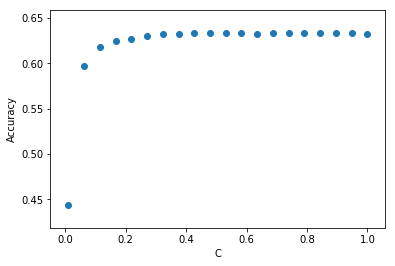

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

mean_scores = []
c_vals = np.linspace(0.01, 1.0, num=20)
for c in c_vals:
    svm = LinearSVC(C=c, max_iter=1000)
    score = cross_validate(svm, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)['test_score']
    mean_scores.append(np.mean(score))
    
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.scatter(x=c_vals, y=mean_scores)
best_c = c_vals[np.argmax(mean_scores)]
print('Best Cross-validation accuracy:', np.max(mean_scores))
print('Best C:', best_c)

But what if you have multiple parameters you want to tune? What if you just don't like writing for-loops? Enter `GridSearchCV`, an expensive and exhaustive way to search for ideal parameters. It basically does the same thing as the previous code except you don't need to write multiple loops for multiple parameters. You also don't need to retrain your model after you've found the best parameters as `GridSearchCV` will save the best performing model and parameters.

All you need to do is create a dictionary with the parameters you're wanting to try. In our case, we will use the same `C` values as last time, but also try the two different loss functions available to `LinearSVC`. Again, this can get expensive. Last time, we trained $100$ models. This time, we're training $2 \times 20 \times 5 = 200$ models to see which parameters work well.

In [50]:
from sklearn.model_selection import GridSearchCV

params = {
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.1, 1.0, num=20)
}
svm_optimized = GridSearchCV(LinearSVC(), params, scoring='accuracy', n_jobs=-1, cv=5)
svm_optimized.fit(X_train, y_train)
print(svm_optimized.best_params_)
print(svm_optimized.best_score_)

{'C': 0.5263157894736842, 'loss': 'squared_hinge'}
0.6335299901671583


63% is, admittedly, not that great a number. But honestly, it's a hard task. I don't know that a well-versed human would be able to read these titles and be great at predicting which titles came from which subreddits, especially given that they're similar in subject. I imagine that with less similar subreddits, your accuracy should get much higher. Using more robust models such as Neural Networks _might_ get us higher performance, but that's out of scope of this tutorial.

With all that, let's finally test our model performance on our test set. If all went well, the cross-validated score should be very close to the test accuracy.

In [61]:
from sklearn.metrics import accuracy_score

svm_predictions = svm_optimized.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, svm_predictions))

Test accuracy: 0.6470138410950523


## Actually using the model

Now that we've trained and tuned and trained and tuned our model, how do we use it on new data (text, in our case)? We first need to vectorize the text using $tfidf$ and then put that through the model. Enter `Pipeline`: this object allows you to define the transformations your data needs to go through before classification in one package. 

Usage is quite simple: 
1. Define a list of stuff (string, object) for your data to go through
2. Pass that into `Pipeline`
3. Profit

In [63]:
from sklearn.pipeline import Pipeline

stuff = [('tf-idf', vectorizer), ('svm', svm_optimized)]
pipeline = Pipeline(stuff)
pipeline.predict(X_test_text) # X_test_text is raw text

array([ 9, 12,  0, ..., 14,  6, 10])